<a href="https://colab.research.google.com/github/dfirm/iads_day8/blob/main/FE_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sagihaider/IADS_SC_2021_TransferLearning.git

from zipfile import ZipFile
file_name = "/content/IADS_SC_2021_TransferLearning/data.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')



Cloning into 'IADS_SC_2021_TransferLearning'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.
done


In [2]:
!pip install tensorflow
!pip install keras

In [3]:
import numpy as np
import os
import time
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
# from keras.applications.imagenet_utils import preprocess_input
# from keras.applications.imagenet_utils import decode_predictions
# from keras.layers import Dense, Activation, Flatten
# from keras.layers import merge, Input
# from keras.models import Model
# from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [4]:
#Loading the training data

PATH = os.getcwd()
# Define data path
data_path = PATH + '/data'
data_dir_list = os.listdir(data_path)

#%% 

img_data_list=[]

for dataset in data_dir_list:
	img_list=os.listdir(data_path+'/'+ dataset)
	print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
	for img in img_list:
		img_path = data_path + '/'+ dataset + '/'+ img
		img = image.load_img(img_path, target_size=(224, 224))
		x = image.img_to_array(img)
		x = np.expand_dims(x, axis=0)
		x = preprocess_input(x)
#		x = x/255
#		print('Input image shape:', x.shape)
		img_data_list.append(x)

#%% 
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

Loaded the images of dataset-Humans

Loaded the images of dataset-horses

Loaded the images of dataset-cats

Loaded the images of dataset-dogs

(808, 1, 224, 224, 3)
(1, 808, 224, 224, 3)
(808, 224, 224, 3)


In [5]:
#Define the number of classes
import tensorflow as tf
 

num_classes = 4
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:202]=0
labels[202:404]=1
labels[404:606]=2
labels[606:]=3

names = ['cats','dogs','horses','humans']

# convert class labels to on-hot encoding
Y = tf.keras.utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


In [6]:
IMG_SIZE = 224
LR = 1e-4

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [8]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]

In [11]:
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
out = Dense(4, activation='softmax', name='output')(x)  ## 2 classes
model = Model(img_input, out)

for layer in model.layers[:-3]:
	layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]

In [14]:
history = model.fit(X_train, y_train,
                    batch_size=20,
                    epochs=20,
                    validation_data=(X_test,y_test),
                    callbacks=my_callbacks)

Epoch 1/20
33/33 [==============================] - 401s 12s/step - loss: 1.4984 - acc: 0.8854 - val_loss: 0.3866 - val_acc: 0.9630
Epoch 2/20
33/33 [==============================] - 400s 12s/step - loss: 0.1434 - acc: 0.9876 - val_loss: 0.6566 - val_acc: 0.9691
Epoch 3/20
33/33 [==============================] - 396s 12s/step - loss: 0.0401 - acc: 0.9985 - val_loss: 0.1141 - val_acc: 0.9691
Epoch 4/20
33/33 [==============================] - 400s 12s/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.1193 - val_acc: 0.9877
Epoch 5/20
33/33 [==============================] - 400s 12s/step - loss: 2.2731e-06 - acc: 1.0000 - val_loss: 0.1268 - val_acc: 0.9877
Epoch 6/20
33/33 [==============================] - 400s 12s/step - loss: 5.2868e-07 - acc: 1.0000 - val_loss: 0.1271 - val_acc: 0.9877
Epoch 7/20
33/33 [==============================] - 399s 12s/step - loss: 2.8102e-07 - acc: 1.0000 - val_loss: 0.1270 - val_acc: 0.9877
Epoch 8/20
33/33 [==============================] - 400s 12s/ste

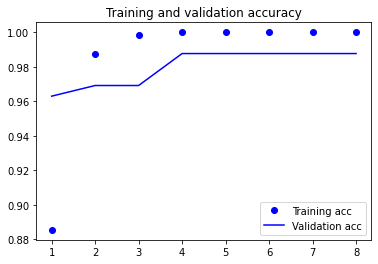

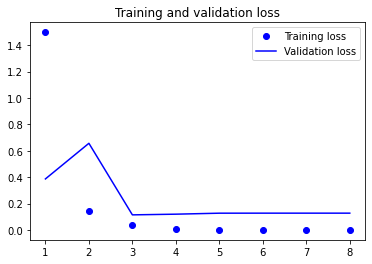

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(X_test)
ypred = predictions > 0.5
test_acc = accuracy_score(y_test, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(y_test, ypred, average='weighted')

auc = roc_auc_score(y_test, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 1.0
Val Accuracy:	 0.9876543283462524
Test Accuracy:	 0.9691358024691358
Precision:	 0.9705882352941178
Recall:		 0.9691358024691358
F1 Score:	 0.9694100522335403
AUC:		 0.9790304364095022
